In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [18]:
import os

In [25]:
results_path = 'classification_results_path/'

In [32]:
df = pd.read_csv('classification_results_path/scores_for_sub_table_for_rosenfeld_f_metric__accuracy__harmonic_mean.csv').set_index('Unnamed: 0')

In [51]:
list_of_metrics = [
    pd.read_csv(results_path + filename)\
    .rename(columns={'Unnamed: 0': 'Model'})\
    .set_index('Model')\
    .stack()\
    .rename(filename.split('scores_for_sub_table_for_')[1][:-4])\
    for filename in os.listdir(results_path) if filename.startswith('scores')
]

In [69]:
pd.concat(list_of_metrics,axis=1).stack().unstack('Model').loc['Accuracy'].max(axis=1)

rosenfeld_f_metric__accuracy__harmonic_mean     0.48
rosenfeld_f_metric__accuracy__mean              0.56
rosenfeld_f_metric__precision__harmonic_mean    0.56
rosenfeld_f_metric__precision__mean             0.44
rosenfeld_f_metric__r2__harmonic_mean           0.36
rosenfeld_f_metric__r2__mean                    0.56
rosenfeld_f_metric__recall__harmonic_mean       0.56
rosenfeld_f_metric__recall__mean                0.60
dtype: float64

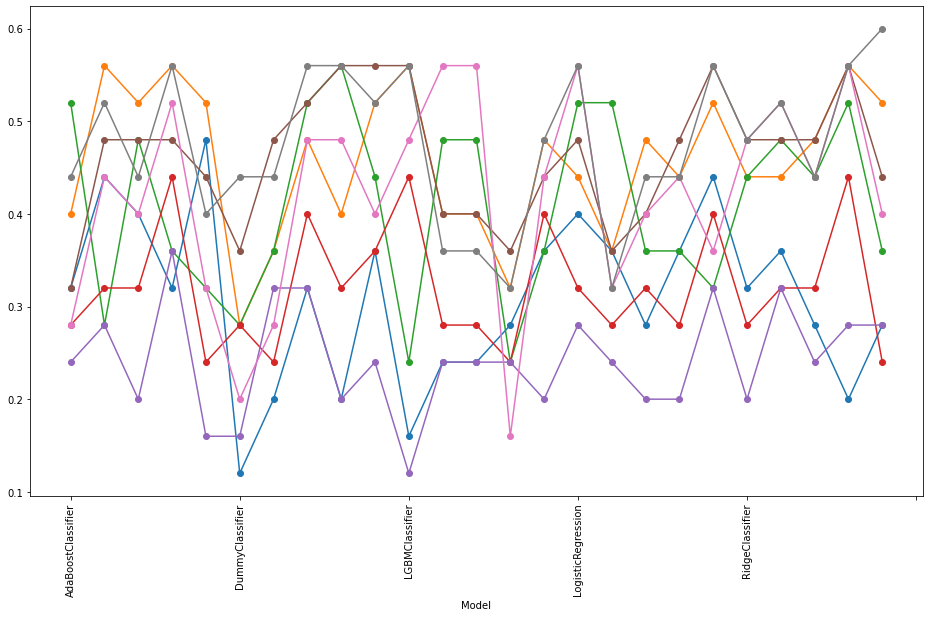

In [61]:
pd.concat(list_of_metrics,axis=1).stack().unstack('Model').loc['Accuracy'].T.plot(figsize=(16,9),marker='o', legend=None)
plt.xticks(rotation=90);

# look at predictions

In [73]:
preds_df = pd.read_csv('classification_results_path/predictions_for_sub_table_for_rosenfeld_f_metric__accuracy__harmonic_mean.csv').rename(columns={'Unnamed: 0': 'dataset'}).set_index('dataset')

In [89]:
preds_df.truth.value_counts()

symmetrical_uncertainty-linear_svc       7
symmetrical_uncertainty-decision_tree    4
chi_square-decision_tree                 4
chi_square-linear_svc                    3
pearson_correlation-decision_tree        3
fishers_score-linear_svc                 1
pearson_correlation-linear_svc           1
remove_low_variance-decision_tree        1
information_gain-linear_svc              1
Name: truth, dtype: int64

In [88]:
pd.concat([preds_df['DummyClassifier'].value_counts(), preds_df.truth.value_counts()],axis=1)

,DummyClassifier,truth
chi_square-linear_svc,8.0,3
symmetrical_uncertainty-linear_svc,8.0,7
information_gain-linear_svc,2.0,1
fishers_score-linear_svc,2.0,1
pearson_correlation-decision_tree,2.0,3
pearson_correlation-linear_svc,1.0,1
chi_square-decision_tree,1.0,4
remove_low_variance-decision_tree,1.0,1
symmetrical_uncertainty-decision_tree,NaN,4


# Trying to show improvement

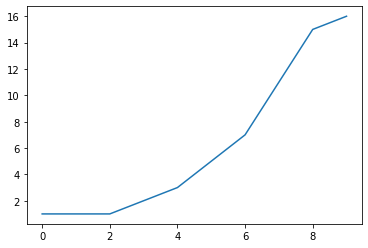

In [90]:
plt.plot([1,1,1,2,3,5,7,11,15,16])

In this section we try to show improvement as the number of features grows. We start with 1 feature and show that the model has poor accuracy, and that the accuracy getting better and better when we add more features. Here's a short POC and we have to generalize it better (

In [93]:
sub_df = pd.read_csv('sub_meta_tables/sub_table_for_rosenfeld_f_metric__accuracy__harmonic_mean.csv').drop('Unnamed: 0', axis=1)

In [95]:
sub_df.head()

,x-row_count,x-col_count,x-col_numerical_count,x-col_categorical_count,x-classes_count,x-cancor,x-kurtosis,x-average_asymmetry_of_features,x-average_linearly_to_target,x-std_linearly_to_target,x-average_correlation_between_features,x-average_coefficient_of_variation_of_feature,x-std_coefficient_of_variation_of_feature,x-average_coefficient_of_anomaly,x-std_coefficient_of_anomaly,x-average_entropy_of_features,x-std_entropy_of_features,best
0,452,281,139,142,13,0.912337,78.024259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
1,2141,5,3,2,3,0.559288,-1.102293,0.891701,0.109790,0.127569,-0.006288,0.788828,0.447162,1.793985,0.989298,7.200235,0.441303,5
2,254,14,1,13,2,0.442837,2.571174,0.742802,0.015614,0.015916,-0.001988,1.399243,0.878175,0.969895,0.464626,4.614663,0.716210,3
3,116,11,10,1,2,0.943995,4.527940,0.352473,0.112689,0.214677,0.168758,0.671816,0.336234,2.150207,1.510576,4.515559,0.181507,5
4,1087,18,14,4,3,0.564348,2.986041,-0.367911,0.015380,0.041234,0.382010,0.369861,0.107348,2.922425,0.792681,6.883867,0.059388,9


In [133]:
import xgboost as xgb

from sklearn.metrics import accuracy_score

In [141]:
X = sub_df[[c for c in sub_df.columns if c.startswith("x-")]].sample(frac=1)
y = sub_df['best'][X.index]

# clean the data and fix anomalies
X.replace(np.inf, np.nan, inplace=True)
X.replace(-np.inf, np.nan, inplace=True)
y.replace(np.inf, np.nan, inplace=True)
y.replace(-np.inf, np.nan, inplace=True)

In [144]:
X.shape

(29, 17)

In [142]:
acc_list = []
for num_of_features in range(1, X.shape[1]):
    newX = X.iloc[:15,:num_of_features]
    # Init classifier
    xgb_cl = xgb.XGBClassifier()

    # Fit
    xgb_cl.fit(newX, y.iloc[:15])

    # Predict
    preds = xgb_cl.predict(X.iloc[15:,:num_of_features])

    acc_list.append(accuracy_score(y.iloc[15:], preds))

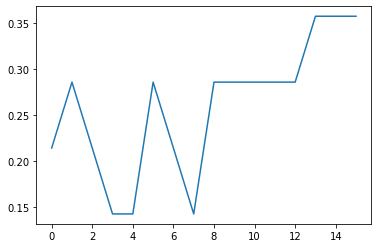

In [143]:
plt.plot(acc_list)